In [1]:
%matplotlib inline

import os
from glob import glob
from collections import defaultdict

import yaml
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import networkx
import dinopy

from phasm.io import gfa
from phasm.io.sequences import FastaSource
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles, superbubble_nodes

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style('whitegrid')

## Bubble chains cover the majority of the assembly graph

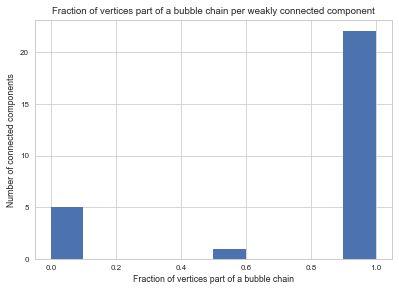

In [5]:
bubblechain_cover = []
for assembly in config['assemblies'].keys():
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    components = glob("{}/03_chain/component[0-9].graphml".format(asm_folder))
    
    for component in components:
        g = networkx.read_graphml(component)
        
        num_bubblechain_vert = 0
        for n in g.nodes_iter():
            if 'bubblechain' in g.node[n]:
                num_bubblechain_vert += 1
        
        bubblechain_cover.append(num_bubblechain_vert / g.number_of_nodes())
    
plt.figure()
plt.title('Fraction of vertices part of a bubble chain per weakly connected component')
plt.ylabel('Number of connected components')
plt.xlabel('Fraction of vertices part of a bubble chain')
plt.hist(bubblechain_cover, bins=10, range=(0.0, 1.0))
plt.savefig(os.path.join(BASE_DIR, 'figures', 'bubblechain-vertices.png'), dpi=256, transparent=True)

## Paths through bubble chains cover larger variants

301
700027
65988.2860825
43712.0


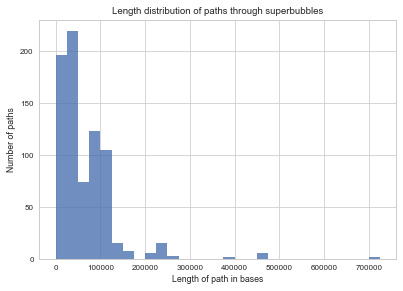

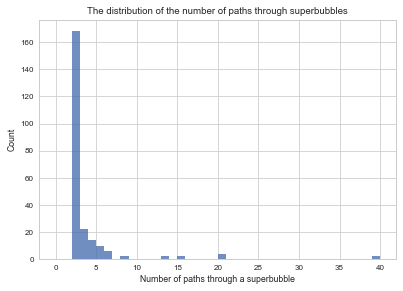

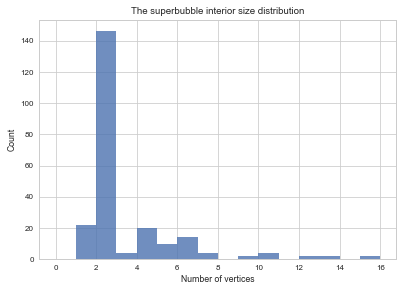

In [14]:
path_data = []
bubble_data = []
for assembly in config['assemblies'].keys():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    bubblechains = glob("{}/03_chain/component[0-9].bubblechain[0-9].graphml".format(asm_folder))
    for bubblechain in bubblechains:
        g = AssemblyGraph(networkx.read_graphml(bubblechain))
        
        for (entrance, exit) in find_superbubbles(g, report_nested=False):
            num_paths  = 0
            total_path_length = 0
            for path in networkx.all_simple_paths(g, entrance, exit):
                path_len = g.path_length(
                    g.node_path_edges(path, data=True), include_last=False)
                path_data.append({
                    'ploidy': ploidy,
                    'coverage': coverage,
                    'path_length': path_len
                })
            
                num_paths += 1
                total_path_length = path_len
            
            interior = superbubble_nodes(g, entrance, exit) - {entrance, exit}
            bubble_data.append({
                'num_paths': num_paths,
                'interior_size': len(interior),
                'average_path_len': total_path_length / num_paths
            })
            
path_df = pd.DataFrame(path_data)
bubble_df = pd.DataFrame(bubble_data)

plt.figure()
plt.title('Length distribution of paths through superbubbles')
bin_size = 25000
bins = list(range(0, path_df['path_length'].max() + bin_size, bin_size))
seaborn.distplot(path_df['path_length'], bins=bins, kde=False, hist_kws={"alpha": 0.8})
plt.ylabel('Number of paths')
plt.xlabel('Length of path in bases')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'path-length-dist.png'), dpi=256, transparent=True)

print(path_df['path_length'].min())
print(path_df['path_length'].max())
print(path_df['path_length'].mean())
print(path_df['path_length'].median())

plt.figure()
plt.title('The distribution of the number of paths through superbubbles')
bin_size = 1
bins = list(range(0, bubble_df['num_paths'].max()+bin_size, bin_size))
seaborn.distplot(bubble_df['num_paths'], kde=False, bins=bins, hist_kws={"alpha": 0.8})
plt.ylabel('Count')
plt.xlabel('Number of paths through a superbubble')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'num-path-dist.png'), dpi=256, transparent=True)

plt.figure()
plt.title('The superbubble interior size distribution')
bin_size = 1
bins = list(range(0, bubble_df['interior_size'].max()+bin_size, bin_size))
seaborn.distplot(bubble_df['interior_size'], kde=False, bins=bins, hist_kws={"alpha": 0.8})
plt.ylabel('Count')
plt.xlabel('Number of vertices')
plt.savefig(os.path.join(BASE_DIR, 'figures', 'interior-size-dist.png'), dpi=256, transparent=True)


In [4]:
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    if coverage != 60:
        continue
        
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    alignments_gfa = os.path.join(asm_folder, "01_overlap", "alignments.gfa")
    with open(alignments_gfa) as f:
        reads = gfa.gfa2_parse_segments(f)
        
    read_source = FastaSource(os.path.join(BASE_DIR, asm_config['reads']))
    
    reference_seqs = {}
    fr = dinopy.FastaReader(os.path.join(BASE_DIR, asm_config['reference']))
    for entry in fr.entries():
        name = entry.name.decode('utf-8').split()[0]
        reference_seqs[name] = entry.sequence.decode('utf-8').upper()
    
    bubblechains = glob("{}/03_chain/component[0-9].bubblechain[0-9].gfa".format(asm_folder))
    for bubblechain in bubblechains:
        print(bubblechain)
        with open(bubblechain) as f:
            graph_reads = gfa.gfa2_parse_segments_with_fragments(f)

        with open(bubblechain) as f:
            g = gfa.gfa2_reconstruct_assembly_graph(f, graph_reads, reads)

        g.sequence_src = read_source
        path_to_ref = {}
    
        for (entrance, exit) in find_superbubbles(g, report_nested=False):
            print("Bubble", entrance, exit)
            refs_included = set()
            for path in networkx.all_simple_paths(g, entrance, exit):
                path = tuple(path)
                path_seq = g.sequence_for_path(
                    g.node_path_edges(path, data=True), include_last=False).decode('utf-8')
                
                path_to_ref[path] = set()
                for ref, ref_seq in reference_seqs.items():
                    # print(type(ref_seq), len(ref_seq), type(path_seq), len(path_seq))
                    rev_comp = dinopy.reverse_complement(path_seq)
                    if path_seq in ref_seq or rev_comp in ref_seq:
                        path_to_ref[path].add(ref)
                        refs_included.add(ref)
                        
                if path_to_ref[path]:
                    print(path, path_to_ref[path])
                


/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/03_chain/component1.bubblechain0.gfa
Bubble merged55+ merged109+
Bubble merged30+ merged55+
Bubble read10815- merged30+
(OrientedRead[id=read10815-, len=12387], OrientedRead[id=read7005+, len=17195], MergedReads[id=merged30, r0=read8271-...r2=read9429-, length=14080]) {'BK006947.3.copy1'}
Bubble merged112+ read10815-
(MergedReads[id=merged112, r0=read2772-...r2=read10087+, length=21422], MergedReads[id=merged96, r0=read10027+...r1=read7427+, length=20920], OrientedRead[id=read10815-, len=12387]) {'BK006947.3.copy0'}
Bubble merged113+ merged112+
Bubble read2715+ merged113+
(OrientedRead[id=read2715+, len=19074], MergedReads[id=merged108, r0=read5044+...r4=read5811-, length=20101], MergedReads[id=merged113, r0=read3342+...r4=read8554+, length=26344]) {'BK006947.3.copy1'}
Bubble merged60+ read2715+
Bubble merged17+ merged60+
Bubble read10591+ merged17+
(OrientedRead[id=read10591+, len=14923], OrientedRead[i

Bubble merged4+ merged51+
Bubble merged11+ merged4+
Bubble merged68+ merged11+
Bubble merged82+ merged68+
Bubble merged81+ merged82+
Bubble read8963+ merged81+
Bubble merged30+ read8963+
Bubble merged45+ merged30+
Bubble merged38+ merged45+
Bubble merged37+ merged38+
Bubble merged33+ merged37+
Bubble merged58+ merged33+
Bubble merged16+ merged58+
Bubble merged44+ merged16+
Bubble merged19+ merged44+
Bubble merged79+ merged19+
Bubble merged83+ merged79+
Bubble merged56+ merged83+
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy4-60x-error-free/03_chain/component0.bubblechain0.gfa
Bubble merged86+ merged84+
Bubble merged20+ merged86+
Bubble merged15+ merged20+
Bubble merged71+ merged15+
Bubble merged27+ merged71+
Bubble merged55+ merged27+
Bubble merged34+ merged55+
Bubble merged7+ merged34+
Bubble merged35+ merged7+
Bubble merged29+ merged35+
Bubble merged1+ merged29+
Bubble read8963- merged1+
Bubble merged80+ read8963-
Bubble merged13+ merged80+
Bubble merged77+ merge

FileNotFoundError: No such file or directory: /run/media/lucas/data/bioinformatics/thesis-data/reads/error_free/ploidy8-60x.fasta